<a href="https://colab.research.google.com/github/RicardoCruzPaulino/test-repo/blob/master/Evaluaci%C3%B3n_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<h2><font color="#004D7F" size=4>Módulo 4</font></h2>



<h1><font color="#004D7F" size=5>Evaluación conocimientos</font></h1>

<br>
<div style="text-align: right">
<font color="#004D7F" size=3>Asociación Popular de Ahorro y Préstamos - APAP</font><br>
<font color="#004D7F" size=3>Prevención y Contro de Fraude
</font><br>
<font color="#004D7F" size=3>Setiembre 2023</font>

</div>

---

<a id="indice"></a>
<h2><font color="#004D7F" size=5>Índice</font></h2>


* [1. Introducción](#section1)
* [2. Preparando los datos](#section2)
   * [Análisis de datos](#section21)
   * [Preprocesamiento](#section22)
* [3. Fase de modelado](#section3)
   * [Gradiente descendiente estocástico (SGD)](#section33)
   * [Regresión logística](#section31)
   * [Support Vector Machine (SVM)](#section32)
   * [Árboles de decision](#section34)
* [4. Conclusiones](#section5)



---

<a id="section1"></a>
## <font color="#004D7F"> 1. Introducción</font>

La presente evaluación tiene como finalidad medir el conocimiento de la herramienta y el proceso de construcción de modelos ya sea de clasificación o predictivos.

En esta evaluación se va a utilizar el dataset [Census Income Dataset](http://archive.ics.uci.edu/ml/datasets/Census+Income). Este dataset contiene datos como la edad, trabajo, estudios, etc. de más de 48K personas.

El objetivo consiste en predecir si dicha persona tiene unos ingresos que superan los 50K dólares anuales; para ello deberá guiarse a través de la metodología CRISP-DM para llevar a cabo el objetivo esperado.


<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<a id="section2"></a>
## <font color="#004D7F"> 2. Preparando los datos</font>


Cargar el dataset indicado y las librerias necesarias para analizar los datos de entrada. Se solicita:

* ¿Que tipos de datos encontramos en el dataset?
* ¿La variable respuesta esta balanceada?



In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from imblearn.under_sampling import RandomUnderSampler


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from imblearn.under_sampling import RandomUnderSampler


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, LabelBinarizer, MultiLabelBinarizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier



# Cargar el dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
column_names = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation",
                "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]
data = pd.read_csv(url, names=column_names, sep=',\s', engine='python')

url_test = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"

test_data = pd.read_csv(url_test, names=column_names, sep=',\s', engine='python')




In [2]:
#Clases y Funciones Utilitarias


#Clases Utilitarias de Transformaciones


class LabelBinarizerForPipeline(BaseEstimator, TransformerMixin):
    """
    Extends LabelBinarizer to work in pipelines for both single and multi-output scenarios.
    """
    def __init__(self, sparse_output=False):
        self.sparse_output = sparse_output
        self.encoder = None  # Initialize encoder as None

    def fit(self, X, y=None):
        """
        Fits the encoder based on the shape of the input data.
        Uses MultiLabelBinarizer for 2D input (multi-output) and LabelBinarizer for 1D input (single-output).
        """
        if X.ndim == 2:  # Check if input is 2D (multi-output)
            self.encoder = MultiLabelBinarizer(sparse_output=self.sparse_output)
        else:
            self.encoder = LabelBinarizer(sparse_output=self.sparse_output)
        self.encoder.fit(X)
        return self

    def transform(self, X, y=None):
        """Transforms the input data using the fitted encoder."""
        return self.encoder.transform(X)


# Clase personalizada para preprocesamiento
class DataPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, numeric_cols, categorical_cols):
        """
        Inicializa el preprocesador con las columnas numéricas y categóricas.

        Args:
            numeric_cols (list): Lista de nombres de columnas numéricas
            categorical_cols (list): Lista de nombres de columnas categóricas
        """
        self.numeric_cols = numeric_cols
        self.categorical_cols = categorical_cols
        self.preprocessor = None

    def fit(self, X, y=None):
        """Ajusta el preprocesador a los datos."""
        # Definimos el ColumnTransformer con los transformadores específicos
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), self.numeric_cols),          # Escala datos numéricos
           #     ('cat', LabelBinarizerForPipeline(), self.categorical_cols)       # Binariza datos categóricos

                 ("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), self.categorical_cols)
            ],
            remainder='passthrough'  # Mantiene las columnas no especificadas sin cambios
        )
        self.preprocessor.fit(X,y)
        return self

    def transform(self, X):
        """Transforma los datos usando el preprocesador ajustado."""
        return self.preprocessor.transform(X)

    def fit_transform(self, X, y=None):
        """Ajusta y transforma los datos en un solo paso."""
        return self.fit(X, y).transform(X)


###  Funciones
def evaluate_model(name, model, y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    print(f"Model: {name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}\n")

# Evaluación del mejor modelo en el conjunto de prueba
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

    #return accuracy, precision, recall, f1, roc_auc



def handle_missing_values(data):
  # Reemplazar valores nulos por NaN
  data.replace('?', np.nan, inplace=True)
  # Imputar valores perdidos en variables numéricas con la mediana
  numeric_imputer = SimpleImputer(strategy='median')
  data[['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']] = numeric_imputer.fit_transform(data[['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']])

  # Imputar valores perdidos en variables categóricas con la moda
  categorical_imputer = SimpleImputer(strategy='most_frequent')
  data[['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']] = categorical_imputer.fit_transform(data[['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']])
  return data

def replace_outliers_with_median(data):
  for column in data.select_dtypes(include=['int64', 'float64']).columns:
    z_scores = stats.zscore(data[column])
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3)
    data[column] = data[column].where(filtered_entries, data[column].median())
    return data

# Aplicar la función a las columnas numéricas

def plot_boxplots(data):
 for col in data.select_dtypes(include=['int64', 'float64']).columns:
      plt.figure(figsize=(10, 4))
      sns.boxplot(x=data[col])
      plt.title(f'Boxplot for {col}')
      plt.show()



def plot_scatter_plots(data):
  for column in data.select_dtypes(include=['int64', 'float64']).columns:
     if column != 'income':
      plt.figure(figsize=(10, 6))
      sns.scatterplot(x=data[column], y=data['income'])
      plt.title(f'Scatter plot of {column} vs Income')
      plt.xlabel(f'{column}')
      plt.ylabel('Income')
      plt.show()



def plot_matrix_correlaciones(data):

# Matriz de correlación
  corr = data.select_dtypes(include=['int64', 'float64']).corr()
  sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
  plt.title('Correlation Matrix')
  plt.show()

def plot_histograms(data):
# Histogramas para variables numéricas
  for col in data.select_dtypes(include=['int64', 'float64']).columns:
      plt.figure(figsize=(10, 4))
      sns.histplot(data[col], kde=True)
      plt.title(f'Histogram for {col}')
      plt.show()





def EDA_data(data):
  print("Dimensiones del dataset")
  data.shape
  print(f"El dataset tiene {data.shape[0]} filas y {data.shape[1]} columnas.")
  print("\n")

  print("Tipos de datos del dataset")
  data.dtypes
  print("\n")

  print("Información del dataset")
  data.info()

  print("Descripción estadística")
  data.describe()

  print("Primeras 5 filas del dataset")
  data.head()

  print("Ultimas 5 filas del dataset")
  data.tail()


  print("Valores nulos en el dataset")
  data.isnull().sum()
  print("\n")

  print("Distribución de la variable objetivo")
  data['income'].value_counts()
  print("\n")
  print("Proporción de cada clase")
  data['income'].value_counts(normalize=True)
  print("\n")

  print("Distribución de las variables categóricas")
  data.select_dtypes(include=['object']).describe()
  print("\n")

  print("Distribución de las variables numéricas")
  data.select_dtypes(include=['int64', 'float64']).describe()
  print("\n")

  print("Tablas de Contingencias variables categóricas vs. variables respuesta")
  plot_tabla_contingencia(data)


  # 1. Boxplots para identificar outliers univariados
  print("# 1. Boxplots para identificar outliers univariados")
  plot_boxplots(data)


  print("# 2. Histogramas para identificar outliers univariados")
  # 2. Histogramas para identificar outliers univariados
  plot_histograms(data)


  print("# 3. Scatter plots para identificar relaciones multivariadas ")
  # 3. Scatter plots para identificar relaciones multivariadas
  plot_scatter_plots(data)

  print("# 4. Matriz de correlación para identificar relaciones inusuales")
  # 4. Matriz de correlación para identificar relaciones inusuales
  plot_matrix_correlaciones(data)


def age_binning(data):
  bins = np.linspace(min(data["age"]), max(data["age"]), 4)
  bins
  group_names = ['Young', 'Adult', 'Elder']

  data['age-binned'] = pd.cut(data['age'], bins, labels=group_names, include_lowest=True )
  data[['age','age-binned']].head(20)
  return data

def plot_tabla_contingencia(data):
# Variables categóricas
  categorical_columns = data.select_dtypes(include=['object']).columns.tolist()

  # Crear tablas de contingencia
  for column in categorical_columns:
      if column != 'income':
          contingency_table = pd.crosstab(data[column], data['income'])
          print(f"Tabla de Contingencia para {column} y income:")
          print(contingency_table)
          print("\n")



# Balancear Muestra aplicando UnderSampling datos en conjuntos de entrenamiento y prueba
def UnderSampling_data(X, y, sampling_strategy = 0.8, test_size=0.3):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
  random_under_sampler = RandomUnderSampler(sampling_strategy=sampling_strategy)
  X_train_res, y_train_res = random_under_sampler.fit_resample(X_train, y_train)
  X_test_res, y_test_res = random_under_sampler.fit_resample(X_test, y_test)
  return  X_train_res,  X_test_res, y_train_res, y_test_res




def best_model(results_models):
  """
  This function selects the best model from a list of model results based on the test score.

  Args:
    results_models: A list of lists, where each inner list represents a model
      and contains [model_name, best_params, best_cv_score, test_score].

  Returns:
    A list containing the name and test score of the best model, or None if
    the input list is empty or invalid.
  """
  if not results_models or not all(isinstance(model_data, list) and len(model_data) == 4 for model_data in results_models):
    return None

  best_model_data = max(results_models, key=lambda x: x[3])  # Find the model with the highest test score

  return [best_model_data[0], best_model_data[1], best_model_data[2], best_model_data[3]] # Return the best model's name and test score




* **¿Que tipos de datos encontramos en el dataset?**

**Respuesta:** Al momnento de ejecucion identificamos que los siguientes tipos datos.
*  Numerico Entero == > int64  (6 variables)
*   Texto ==>  object   (8 variables)

In [3]:
print("Tipo de Datos")
print(data.dtypes)

Tipo de Datos
age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object


**¿La variable respuesta esta balanceada?**

**Repsuesta:** La variable respuesta "target" no se encuentra balanceads .
*  **<=50K:**  Con 24,720 valores para 75.92%
*   **>50K:** Con 7,841 valores para 24.08%

In [4]:
# Distribución de la variable objetivo
income_counts = data['income'].value_counts()
print(income_counts)

# Proporción de cada clase
income_proportion = income_counts / income_counts.sum()
print(income_proportion)

income
<=50K    24720
>50K      7841
Name: count, dtype: int64
income
<=50K    0.75919
>50K     0.24081
Name: count, dtype: float64



---

<a id="section21"></a>
### <font color="#004D7F">Análisis de datos</font>

Realizar un análisis exploratorio de los datos. Responder a las siguientes preguntas (Justifique su respuesta):

* ¿Estan las muestras balanceadas?
* ¿De qué tipo son los datos? ¿Hay que transformarlos?
* ¿Hay valores perdidos? Lleve a cabo el tratamiento adecuado según su criterio para tratar con dichos valores. Justifique su respuesta

###**¿Estan las muestras balanceadas?**

**Respuesta:** Dado que la variable respuesta no esta balanceada, concluimos que las muestras no estan balanceadas. Agregamos gráfico para su comprobación. Estaremo aplicando un balanceo de muestras previo al entrenamiento.

income
<=50K    24720
>50K      7841
Name: count, dtype: int64


<Axes: xlabel='income'>

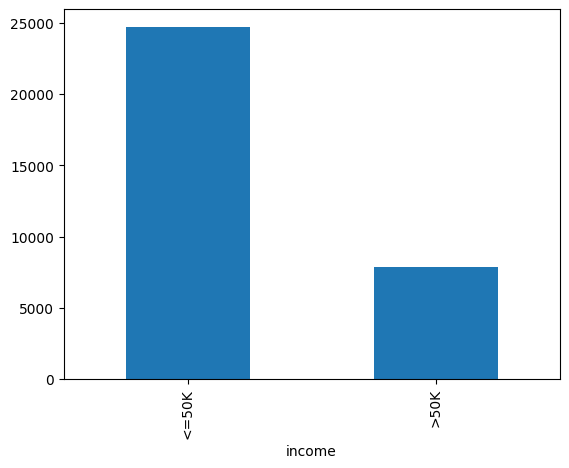

In [5]:
income_counts = data['income'].value_counts()
print(income_counts)
income_counts.plot(kind="bar")

**¿De qué tipo son los datos? ¿Hay que transformarlos?**

**Respuesta:**

**Tipos de Variables de datos**
*   **Numéricas:** age, fnlwgt, education-num, capital-gain, capital-loss, hours-per-week.
*   **Categóricas:** workclass, education, marital-status, occupation, relationship, race, sex, native-country.

**Transformación para Variables de datos**
*   **Numéricas:**  Aplicar Estandarizacion / Escalado, segun criterio seleccionado.
*   **Categóricas:**   Aplicar One-Hot Encoding / Label Encoding, segun aplique para el modelo.


In [6]:
print("Tipos de datos")
print("\n")
print(data.dtypes)

Tipos de datos


age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object


**¿Hay valores perdidos? Lleve a cabo el tratamiento adecuado según su criterio para tratar con dichos valores. Justifique su respuesta**

**Respuesta:**
Al momento de realizar la ejecucion
las siguientes variables presentan valores perdidos:

1.   workclass         1836
2.   occupation        1843
3.   native-country     583


Dado que son variable categoricas, las reemplazaremos con la moda.

In [7]:
print("Revisión datos perdidos")
missing_values = data.isnull().sum()
print(missing_values)

print("Corrección de datos perdidos")
data = handle_missing_values(data)
missing_values = data.isnull().sum()
print(missing_values)


Revisión datos perdidos
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64
Corrección de datos perdidos
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64


¿Existen outliers o valores atípicos? Muestre 2 indicadores (univariados y multivariados) para identificar la existencia de dichos valores. En caso existan, aplique el tratamiento adecuado según su criterio.

**Respuesta:**

Si existen valores atípicos en mas de una variable. Ver los indicadores.

**Indicadores Univariados**
 Para cada variable numerica presentaremos

1.   Boxplots
2.   Histogramas

**Indicadores Multivariados**
Combinaremos la variable respuesta con todas las variables  numericas.

1.   Gráficos de dispersión (scatter plots)
2.   Matriz de correlación:


**Análisis de Outliers**


**Indicadores Univariados**


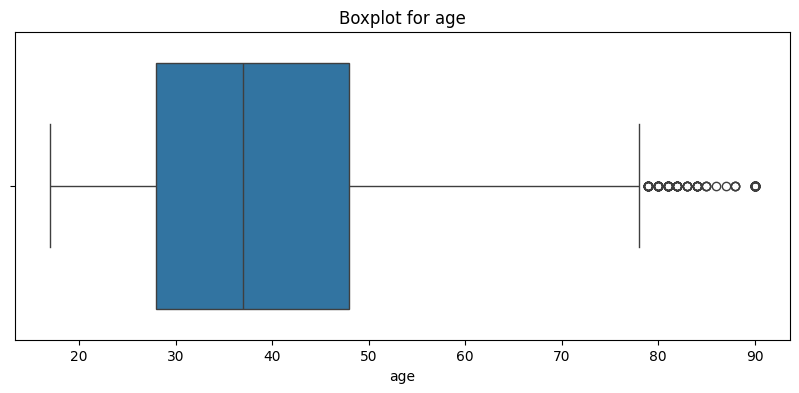

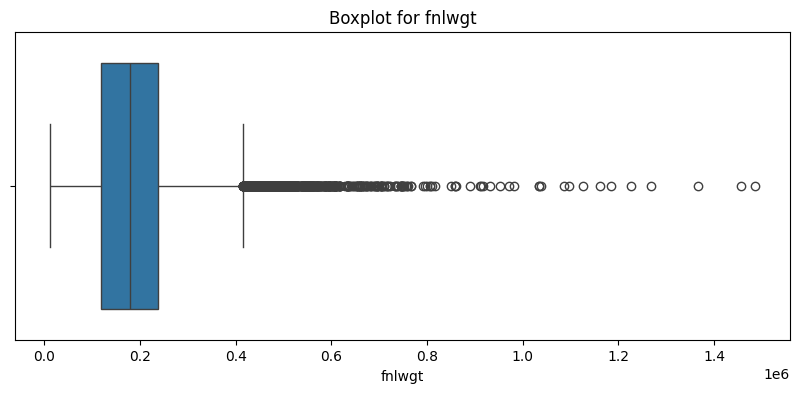

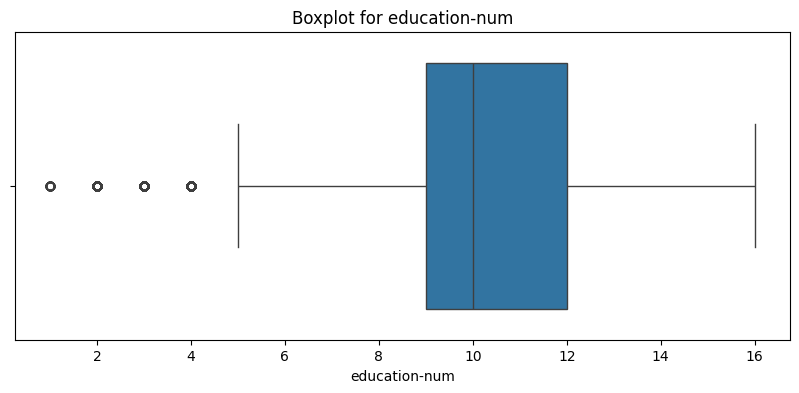

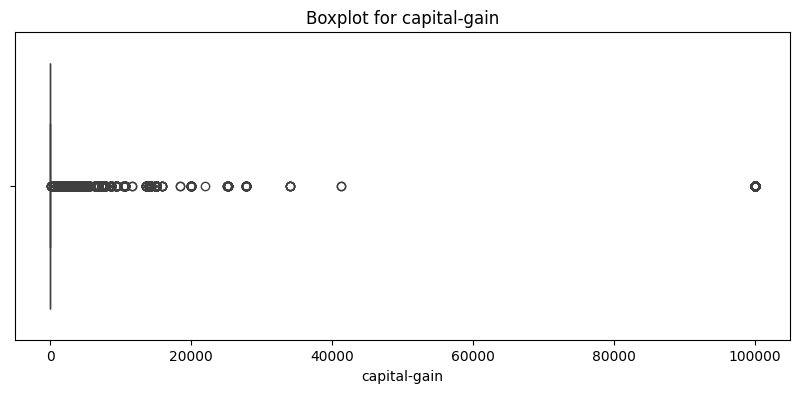

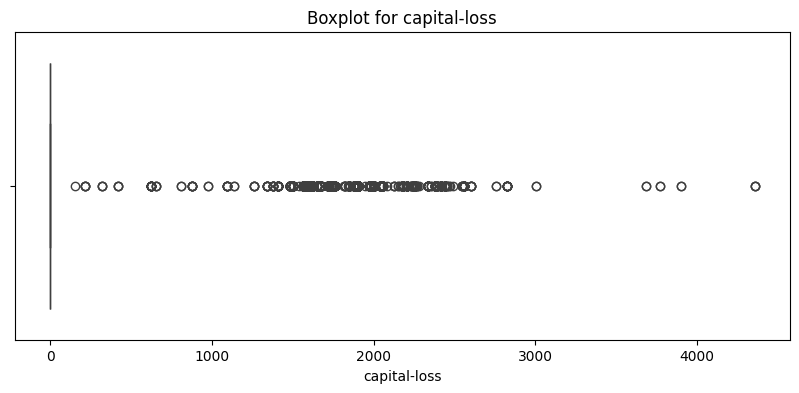

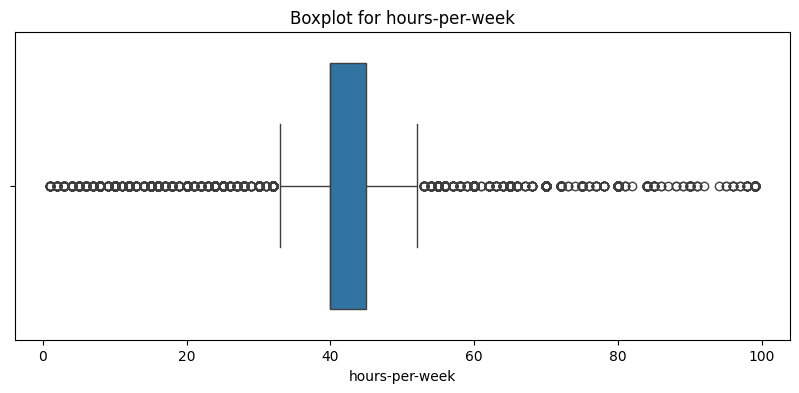

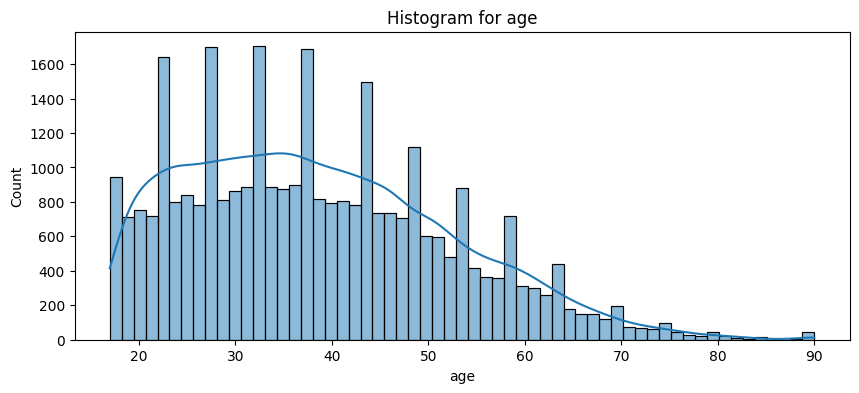

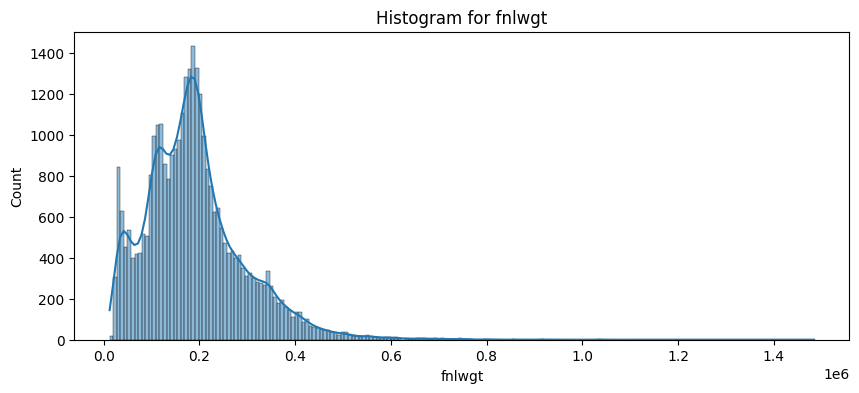

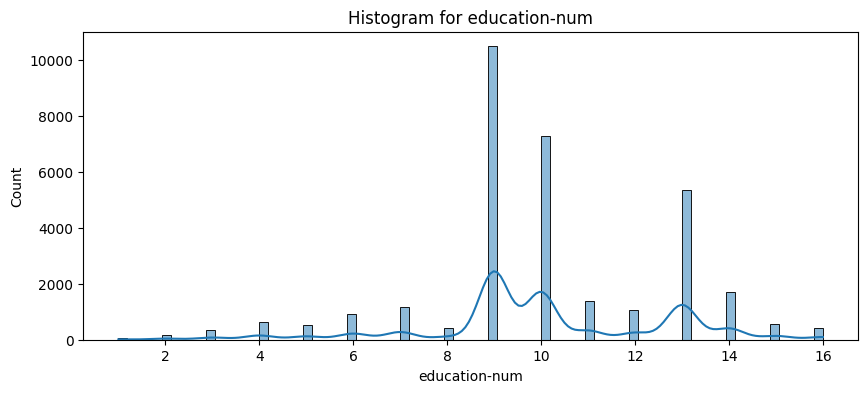

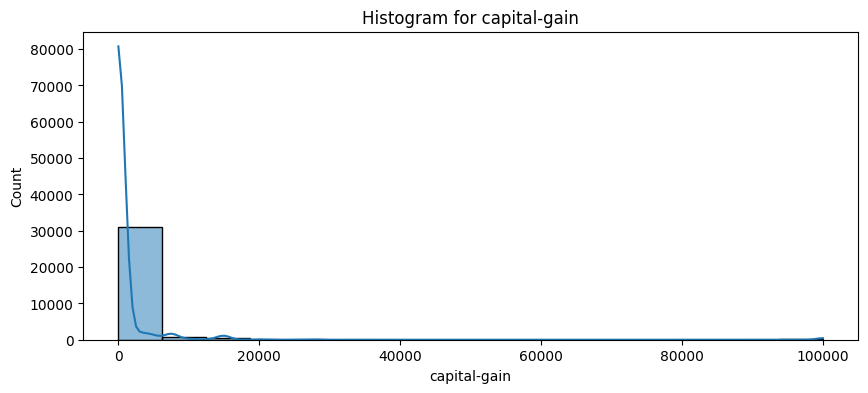

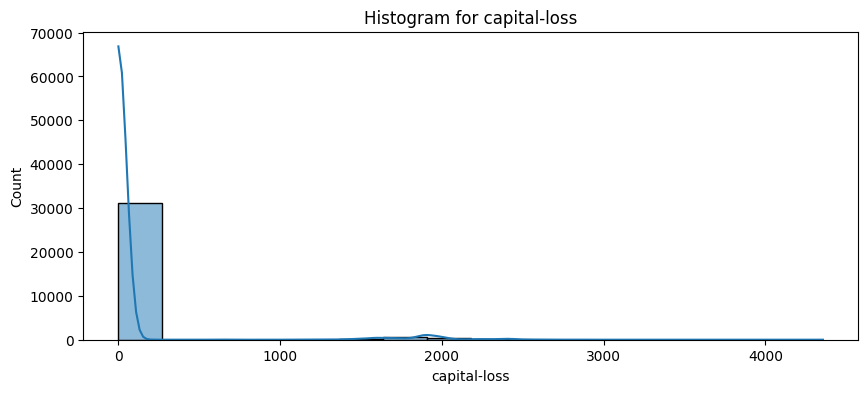

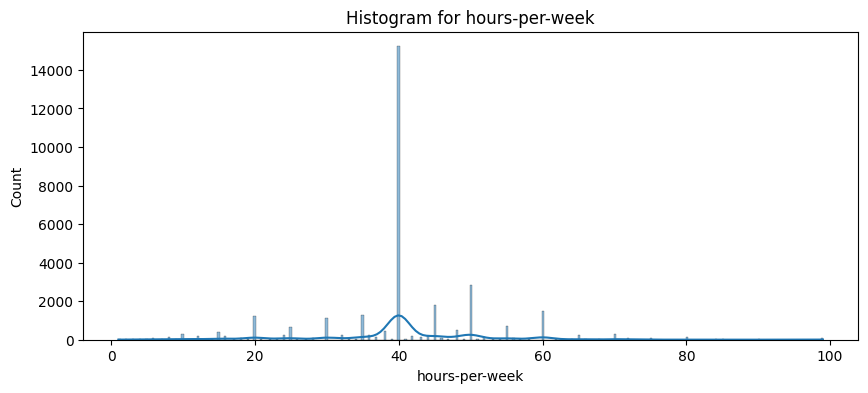



**Indicadores Multivariados**


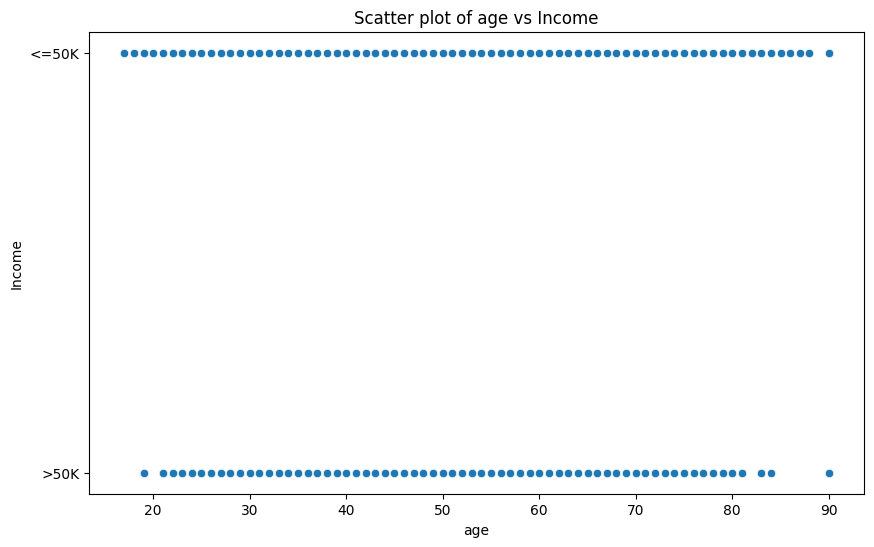

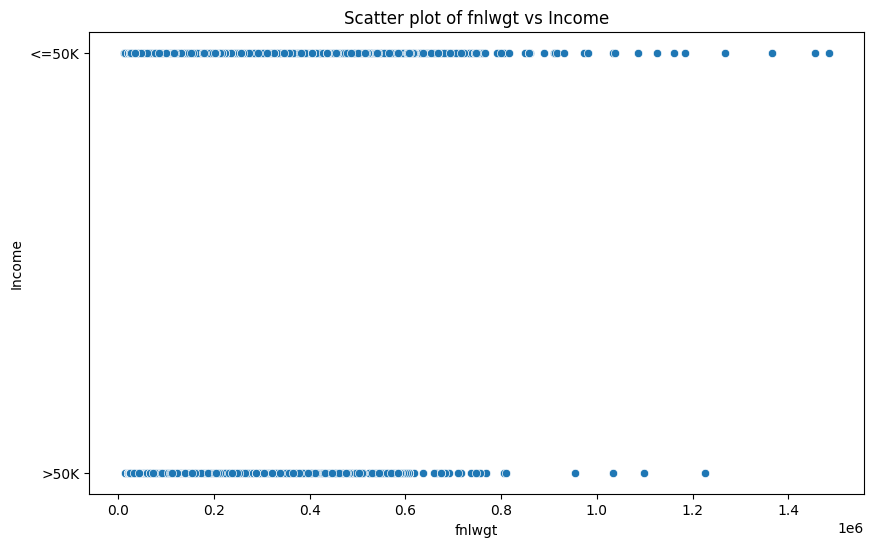

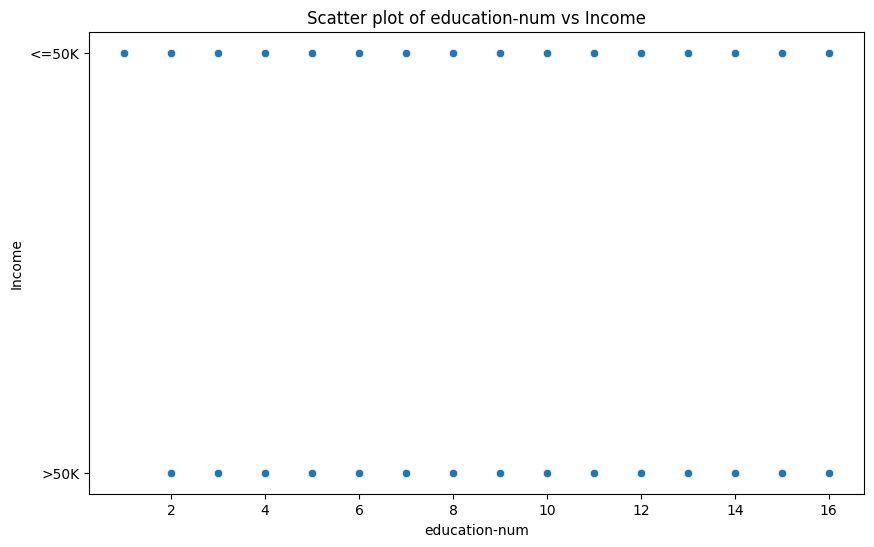

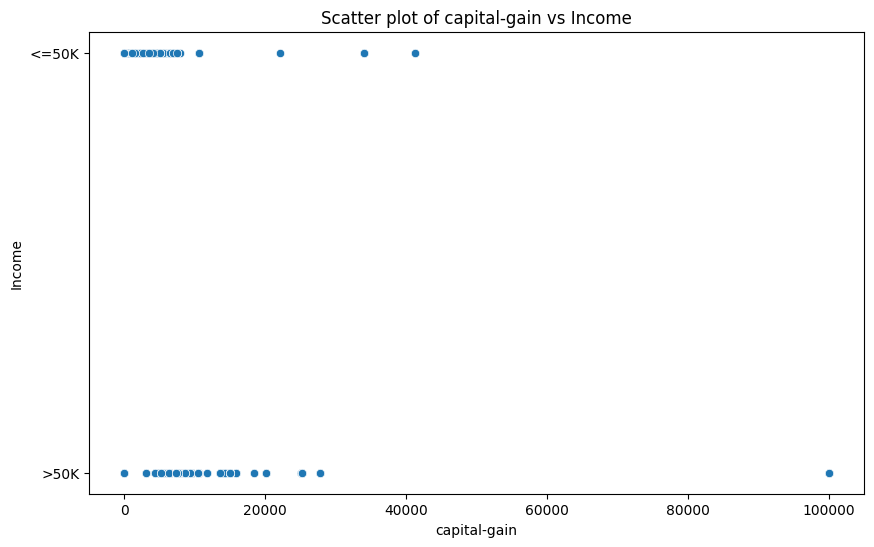

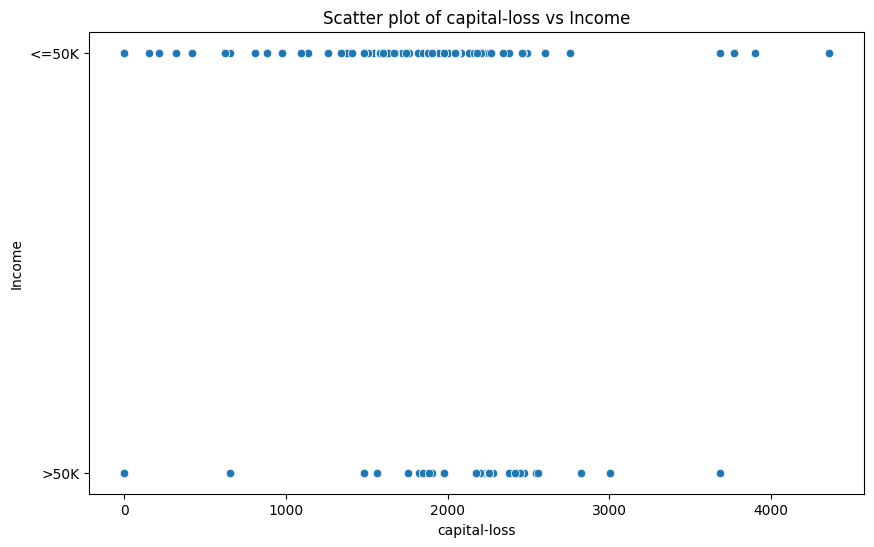

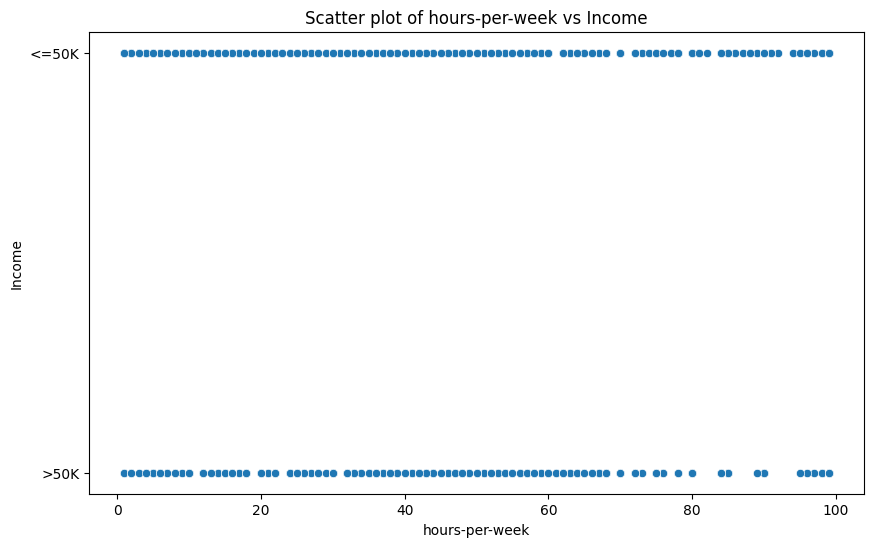

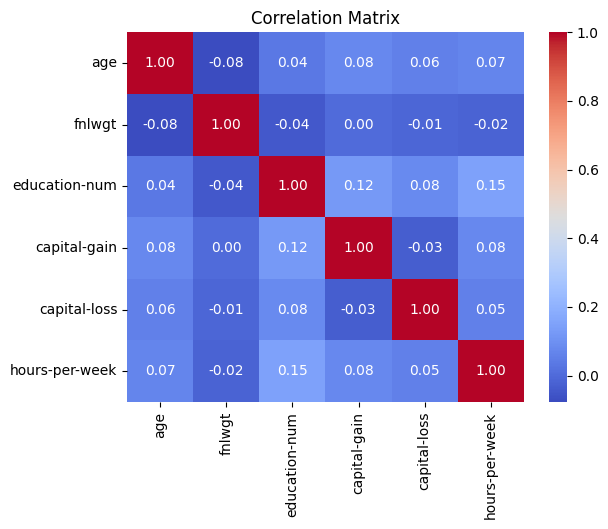



**Tratamiento de Outliers**


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39.0,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53.0,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28.0,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27.0,Private,257302.0,Assoc-acdm,12.0,Married-civ-spouse,Tech-support,Wife,White,Female,0.0,0.0,38.0,United-States,<=50K
32557,40.0,Private,154374.0,HS-grad,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
32558,58.0,Private,151910.0,HS-grad,9.0,Widowed,Adm-clerical,Unmarried,White,Female,0.0,0.0,40.0,United-States,<=50K
32559,22.0,Private,201490.0,HS-grad,9.0,Never-married,Adm-clerical,Own-child,White,Male,0.0,0.0,20.0,United-States,<=50K


In [8]:

print("**Análisis de Outliers**")
print("\n")
#
#**Indicadores Univariados**
print("**Indicadores Univariados**")
plot_boxplots(data)
plot_histograms(data)
print("\n")
#**Indicadores Multivariados**
print("**Indicadores Multivariados**")
plot_scatter_plots(data)
plot_matrix_correlaciones(data)

print("\n")
print("**Tratamiento de Outliers**")
replace_outliers_with_median(data)



LLeve a cabo un análisis descriptivo mediante tablas y gráficos (univariados y bivariados) Ejemplo: Histogramas, matriz de correlaciones, etc. Comente sus hallazgos.

**Análisis descriptivo**
Dimensiones del dataset
El dataset tiene 32561 filas y 15 columnas.


Tipos de datos del dataset


Información del dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             32561 non-null  float64
 1   workclass       32561 non-null  object 
 2   fnlwgt          32561 non-null  float64
 3   education       32561 non-null  object 
 4   education-num   32561 non-null  float64
 5   marital-status  32561 non-null  object 
 6   occupation      32561 non-null  object 
 7   relationship    32561 non-null  object 
 8   race            32561 non-null  object 
 9   sex             32561 non-null  object 
 10  capital-gain    32561 non-null  float64
 11  capital-loss    32561 non-null  float64
 12  hours-per-week  32561 non-null  float64
 13  native-country  32561 non-null  object 
 14  income          32

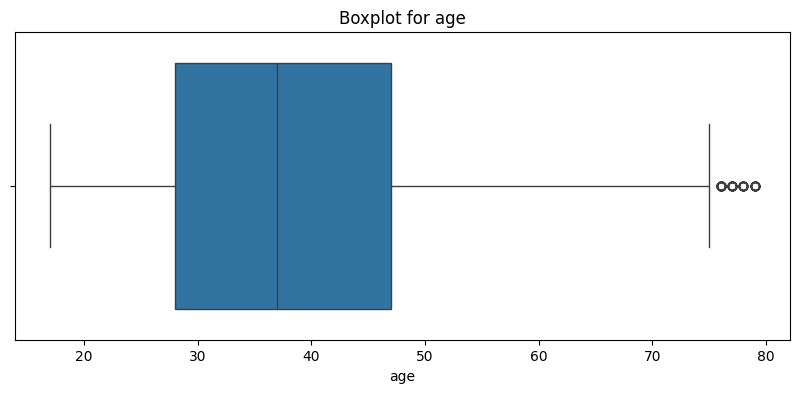

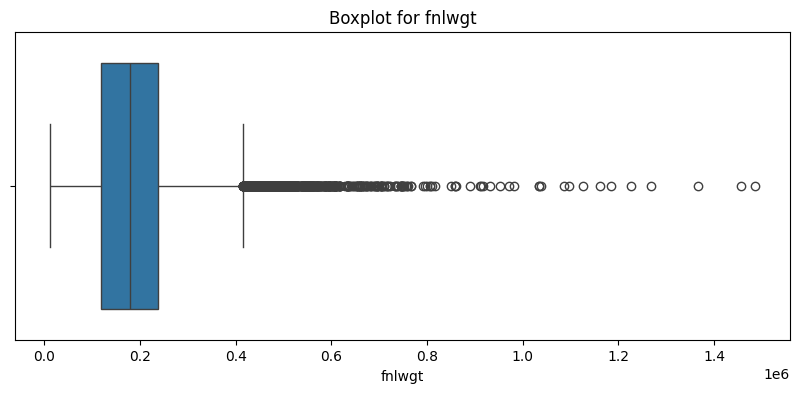

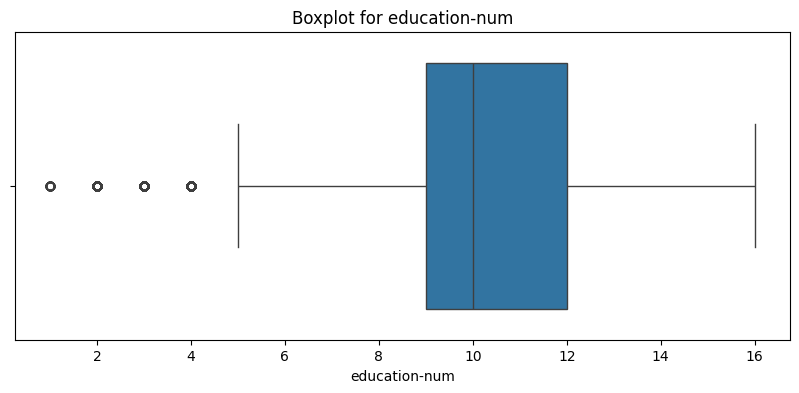

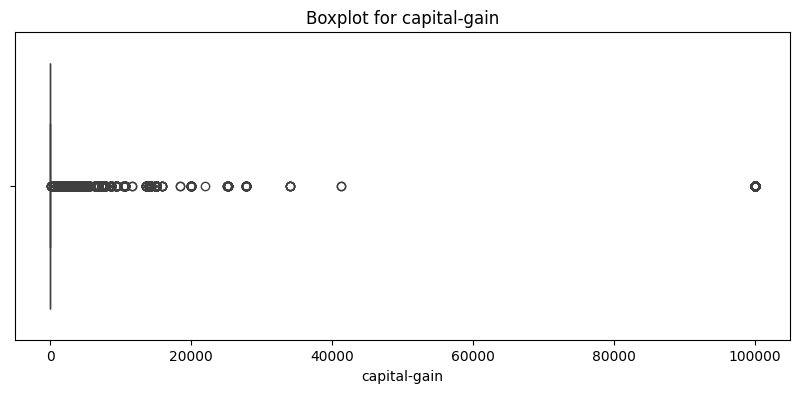

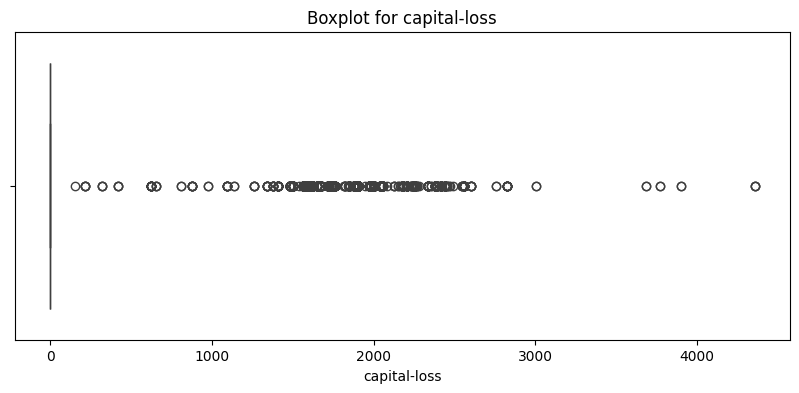

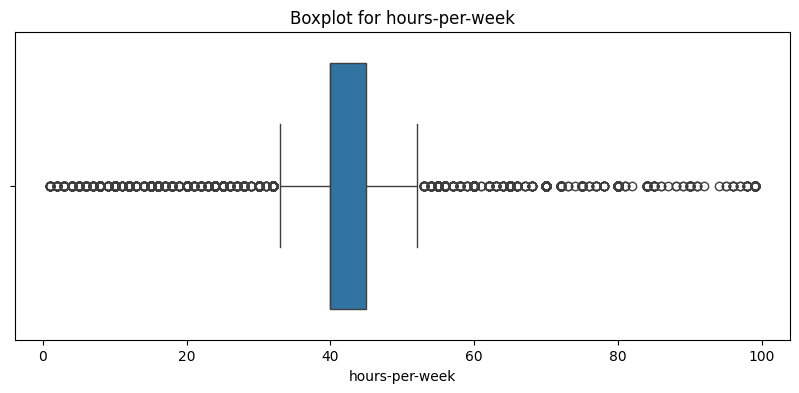

# 2. Histogramas para identificar outliers univariados


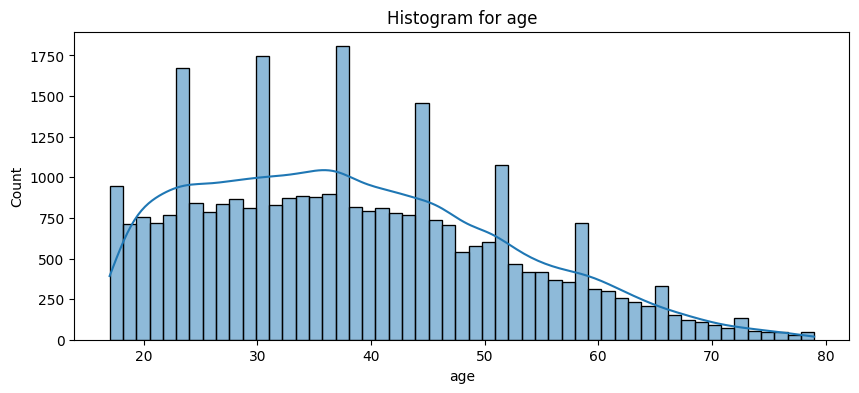

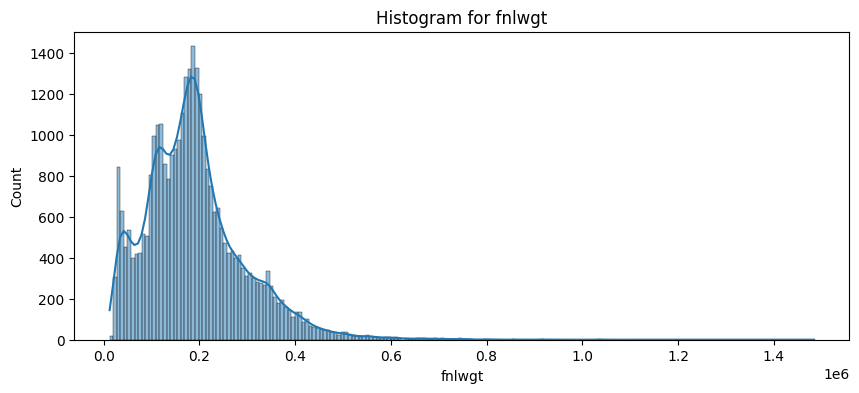

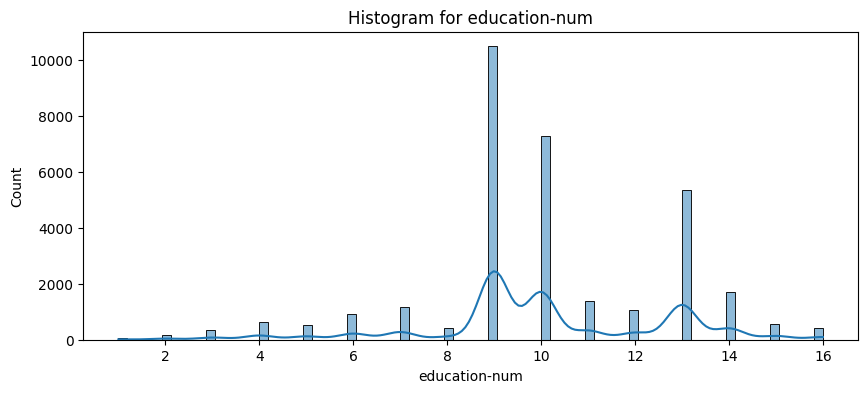

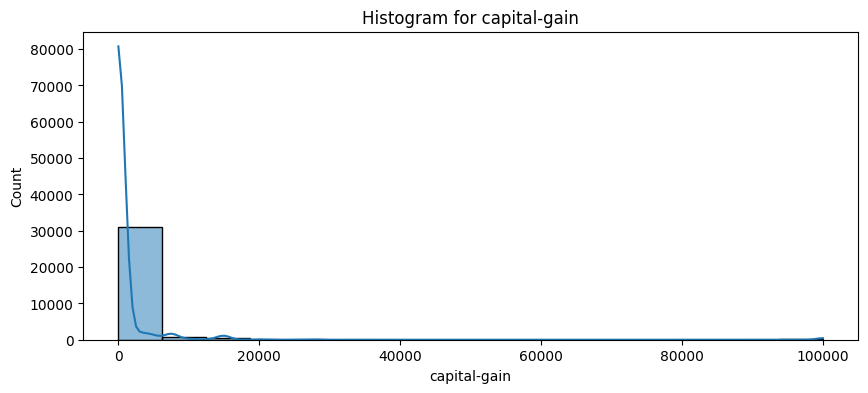

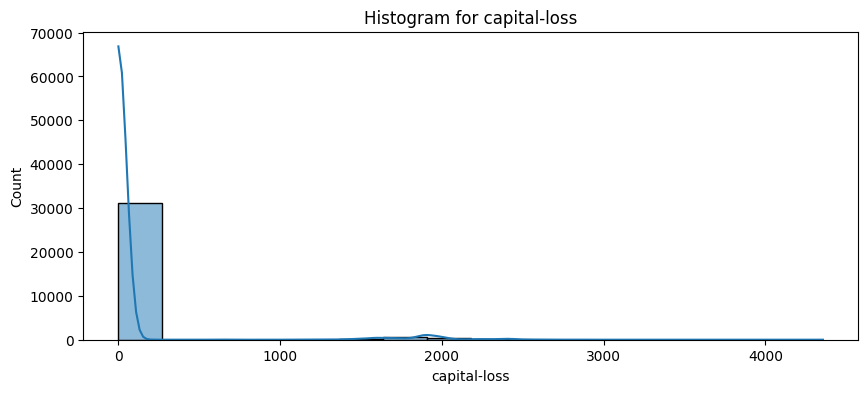

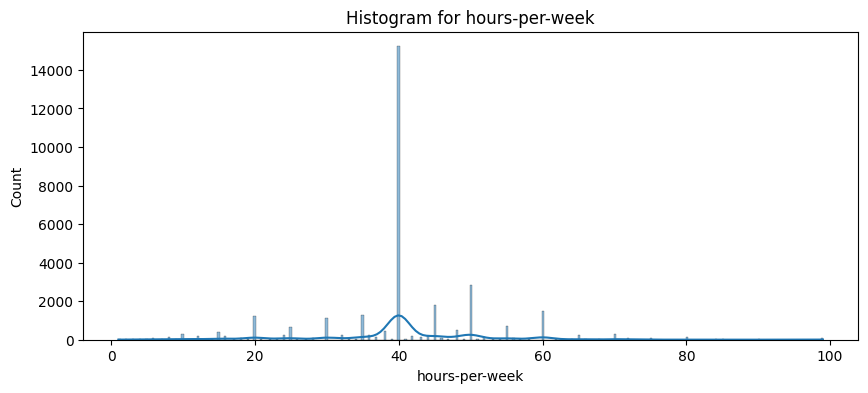

# 3. Scatter plots para identificar relaciones multivariadas 


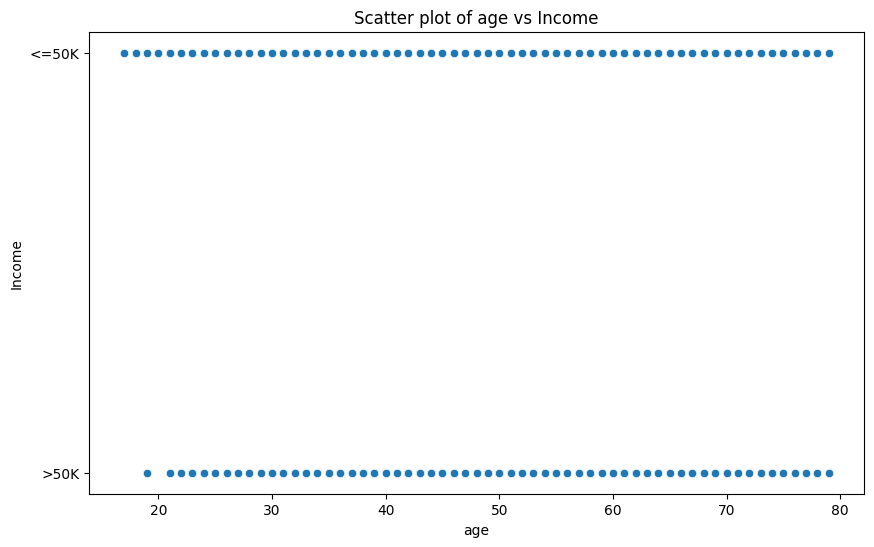

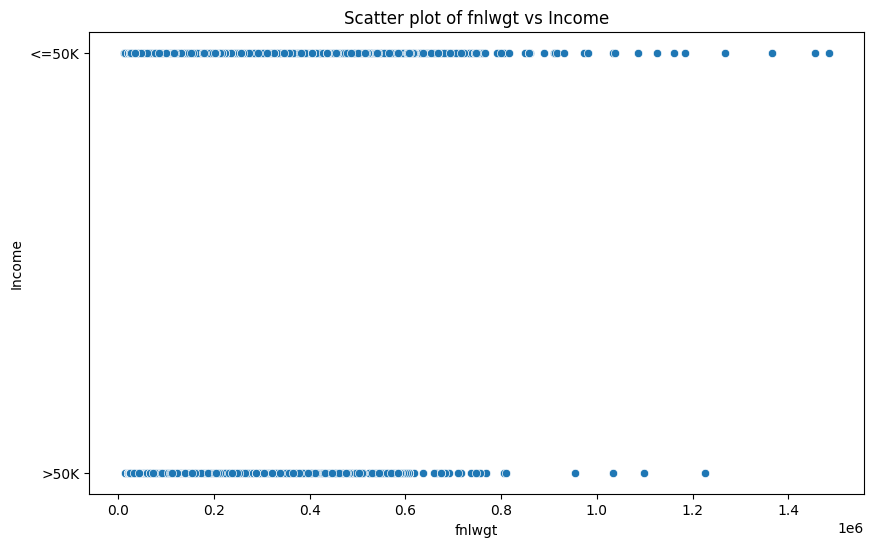

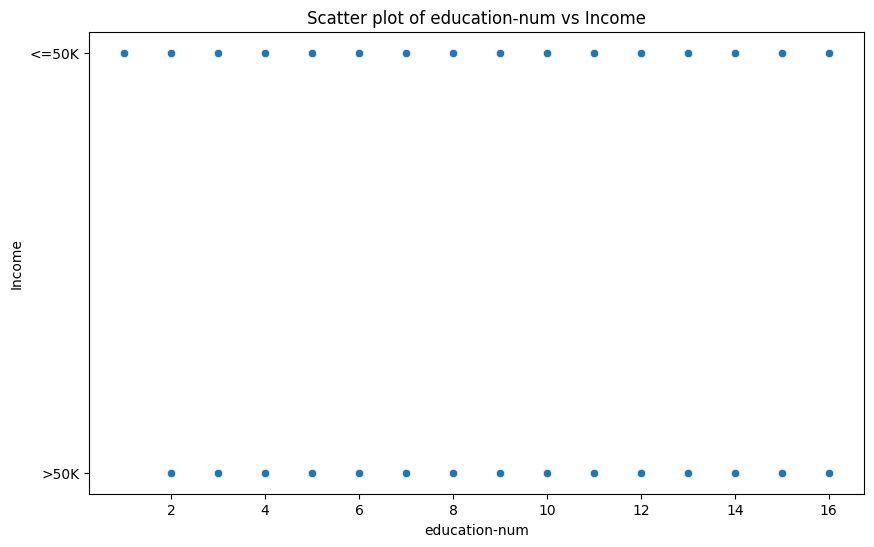

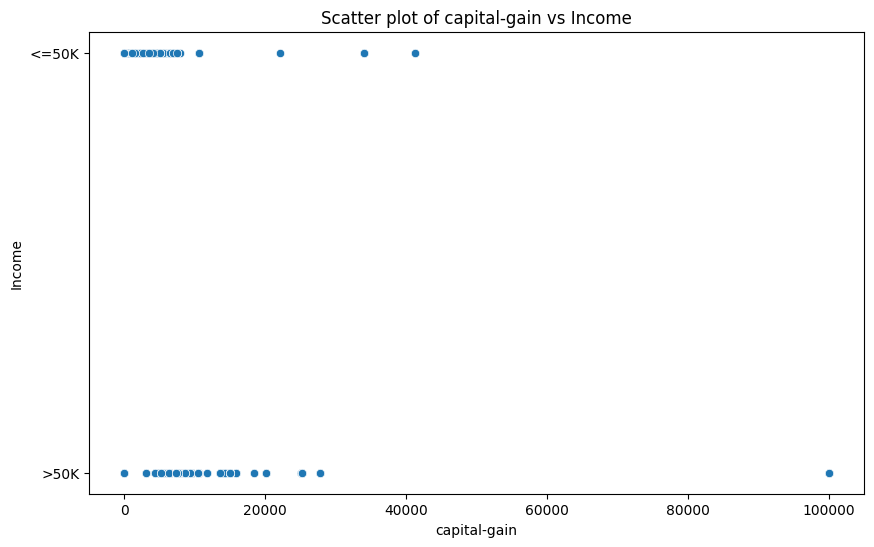

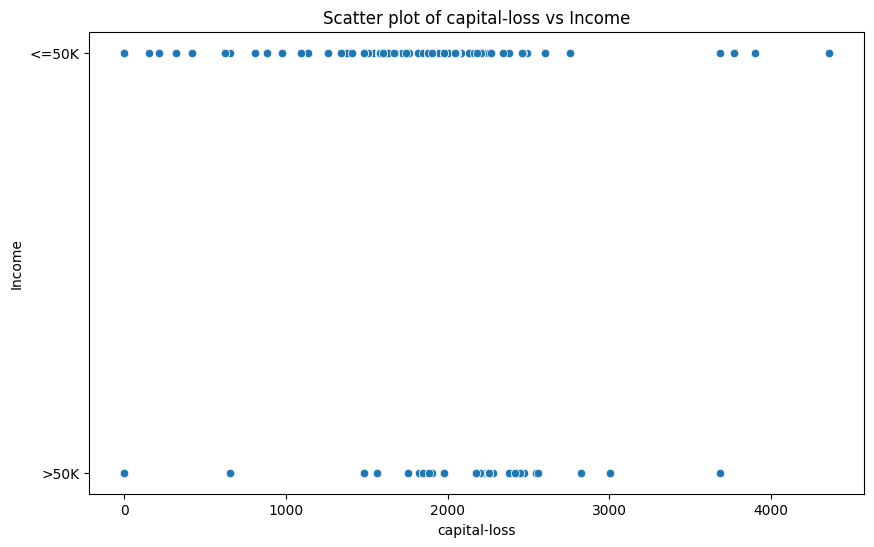

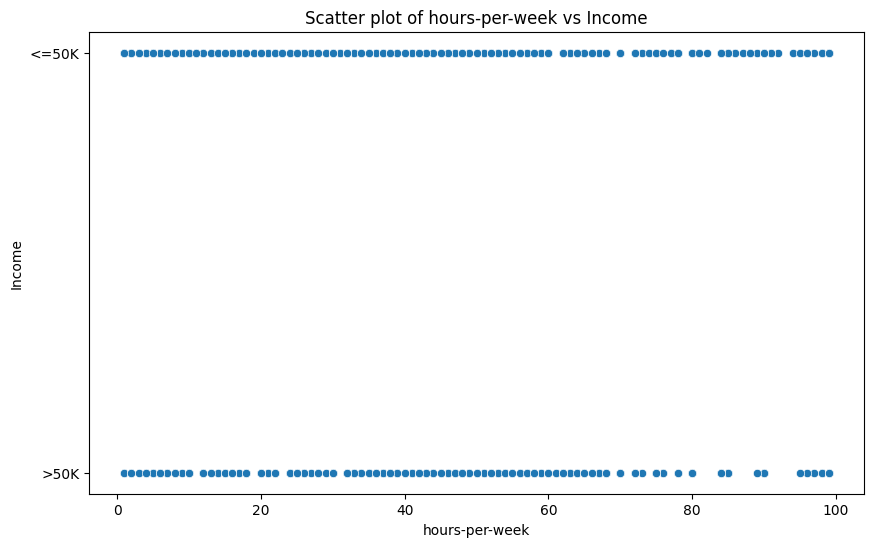

# 4. Matriz de correlación para identificar relaciones inusuales


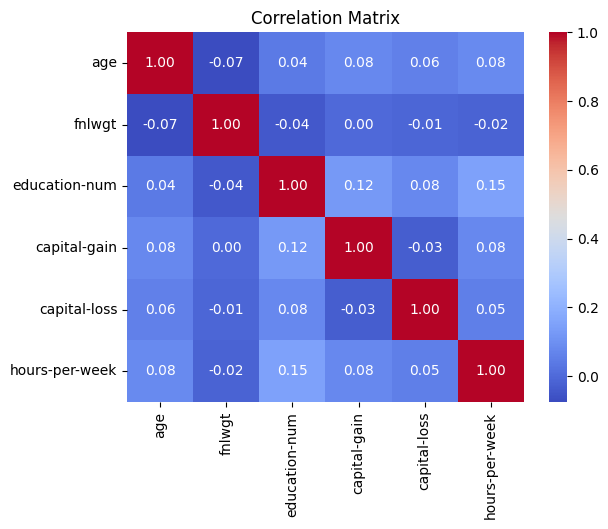

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("**Análisis descriptivo**")
eda_data = data.copy()
EDA_data(eda_data)


<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Si tuviesemos que imputar valores a alguna columna, se podría utilizar el valor medio o mediana para las variables numéricas y el valor más frecuente para las categóricas.
</div>

---

<a id="section22"></a>
### <font color="#004D7F">Preprocesamiento</font>

Antes de realizar las transformaciones necesarias tenemos que realizar la partición entre muestras de train y test. LLeve a cabo dicha partición.

In [10]:

# Aplicamos Binning a la variable Age

def age_binning(data):
  bins = np.linspace(min(data["age"]), max(data["age"]), 4)
  bins
  group_names = ['Young', 'Adult', 'Elder']

  data['age-binned'] = pd.cut(data['age'], bins, labels=group_names, include_lowest=True )
  data[['age','age-binned']].head(20)
  return data

print("Aplicamos Binning a la variable Age ")
data = age_binning(data)
data.head()


X = data.drop("income", axis=1)

print("Preparamos el Dataset Train")
# Binarizamos la variable respuesta
print ("Binarizamos la variable respuesta")
print("Pre Binarizar")
print(data["income"].unique())
data["income"].unique()

y = data["income"].apply(lambda x: 1 if x == '>50K' else 0)
print("Post Binarizar")
data["income"].unique()
# Dividir datos en entrenamiento y prueba

print("Aplicamos la funcion de Undersampling para balancear el dataset")

X_train, X_test, y_train, y_test = UnderSampling_data(X, y, sampling_strategy = 0.8, test_size=0.3 )


Aplicamos Binning a la variable Age 
Preparamos el Dataset Train
Binarizamos la variable respuesta
Pre Binarizar
['<=50K' '>50K']
Post Binarizar
Aplicamos la funcion de Undersampling para balancear el dataset


¿Es necesario estandarizar los datos? Muestre el conjunto de variables a estandarizar.
<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__:
Las clases en SciKit para preprocesar los datos numéricos y categóricos son [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) y [`LabelBinarizer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html), respectivamente.
<div>

**Respuesta:**

Las variables numéricas a estandarizar son:

* **age:** Edad
* **fnlwgt:** Peso final
* **education-num:** Nivel de educación en número de años
* **capital-gain:** Ganancias de capital
* **capital-loss:** Pérdidas de capital
* **hours-per-week:** Horas de trabajo por semana

In [11]:
print("Ver definición de  Clases y Funciones de transformaciones al inicio del Notebook ")

Ver definición de  Clases y Funciones de transformaciones al inicio del Notebook 


Finalmente, para poder utilizar distintos métodos de preprocesamiento sobre el mismo dataset en un Pipeline, tenemos que definir nuestra propia clase de transformación para gestionar los distintos tipos de datos. También se podría hacer con la clase [`FeatureUnion`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html), gestionando cada tipo de datos con un pipeline distinto y luego uniéndolos.

Con esto ya hemos definido la transformación de preprocesado que podremos usar en nuestro pipeline.

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: La función [`get_dummies`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) de pandas, por defecto ignora los NaN al hacer el one-hot encoding.
</div>

<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<a id="section3"></a>
## <font color="#004D7F"> 3. Fase de modelado</font>

En SciKit hay multitud de modelos de aprendizaje supervisado ya implementados (https://scikit-learn.org/stable/supervised_learning.html) Algunos de estos modelos son:

1. [Regresión logística](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)
1. [$k$-vecinos más cercanos ($k$-NN)](https://scikit-learn.org/stable/modules/neighbors.html)
1. [Árboles de decisión](https://scikit-learn.org/stable/modules/tree.html)
1. [Support Vector Machine (SVM)](https://scikit-learn.org/stable/modules/svm.html)
1. [Perceptrón multicapa](https://scikit-learn.org/stable/modules/neural_networks_supervised.html)

Algunos de estos modelos son muy sensibles a ciertos aspectos del preprocesamiento de los datos, por ejemplo, al escalado/normalización de las variables, a la codificación de variables categóricas o a la secuencialidad de los datos de entrada. Por lo que es conveniente tener en cuenta estos aspectos en todas las desiciones del proceso, desde el preprocesamiento de los datos a la selección modelos e hiperparámetros. **En la documentación de SciKit para cada uno de los modelos podemos encontrar instrucciones que nos indican/recuerdan estas cuestiones.**

Encontrar el mejor modelo que nos dé el mejor rendimiento con el mejor proceso establecido en los pasos anteriores (Utilize por lo menos 3 técnicas)

In [12]:

# Lista de modelos e hiperparámetros
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000)
    ,    'k-NN': KNeighborsClassifier()
    ,    'Decision Tree': DecisionTreeClassifier()
    ,'Random Forest': RandomForestClassifier(n_estimators=100)
    ,'XGBoost': XGBClassifier()
    ,    'SVM': SVC()
    ,    'MLP': MLPClassifier(max_iter=1000)
}


# Definir la cuadrícula de parámetros para GridSearchCV para cada modelo
param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.1, 1.0, 10.0]
    },
    'k-NN': {
        'classifier__n_neighbors': [3, 5, 7]
    },
    'Decision Tree': {
        'classifier__max_depth': [None, 10, 20]
    },
    'Random Forest': {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [None, 10, 20]
    },

    'XGBoost': {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [3, 5, 7],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__gamma': [0, 0.1]
        },
    'SVM': {
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__kernel': ['linear', 'rbf']
    },
    'MLP': {
        'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'classifier__alpha': [0.0001, 0.001]
    }
}

In [13]:
## usar pipeline

results_models=[]
numeric_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_features = ['age-binned', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']



# Entrenar y evaluar cada modelo usando GridSearchCV
for model_name in models:

    pipeline = Pipeline(steps=[
          ('preprocessor', DataPreprocessor(numeric_cols=numeric_features,
                                   categorical_cols=categorical_features)),
            ("classifier", models[model_name])
    ])

    grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=5)
    grid_search.fit(X_train, y_train)

    print(f"Modelo: {model_name}")
    print("Mejores parámetros encontrados: ", grid_search.best_params_)
    print("Mejor puntuación de validación cruzada: ", grid_search.best_score_)

    # Evaluar el modelo en el conjunto de prueba
    test_score = grid_search.score(X_test, y_test)
    print("Puntuación en el conjunto de prueba: ", test_score)
    print("\n")

    results_models.append([model_name, grid_search.best_params_, grid_search.best_score_, test_score])


print("Resultados de los Modelos")
print (results_models)
print("\n")

print("Mejor Modelo")
best_model_info = best_model(results_models)
if best_model_info:
    best_model_name, best_model_parameters, best_model_train_score ,  best_model_test_score = best_model_info
    print(f"El mejor modelo es: {best_model_name} con una puntuación en el conjunto de prueba de: {best_model_test_score}")
else:
    print("No se pudo determinar el mejor modelo.")

best_model = models[best_model_name]

print("\n")

Modelo: Logistic Regression
Mejores parámetros encontrados:  {'classifier__C': 1.0}
Mejor puntuación de validación cruzada:  0.8254121431443504
Puntuación en el conjunto de prueba:  0.8180945063388398


Modelo: k-NN
Mejores parámetros encontrados:  {'classifier__n_neighbors': 7}
Mejor puntuación de validación cruzada:  0.7971049457177323
Puntuación en el conjunto de prueba:  0.7961966961198617


Modelo: Decision Tree
Mejores parámetros encontrados:  {'classifier__max_depth': 10}
Mejor puntuación de validación cruzada:  0.8175311620426216
Puntuación en el conjunto de prueba:  0.8115635804840569


Modelo: Random Forest
Mejores parámetros encontrados:  {'classifier__max_depth': 20, 'classifier__n_estimators': 300}
Mejor puntuación de validación cruzada:  0.8310414153598712
Puntuación en el conjunto de prueba:  0.8250096043027276


Modelo: XGBoost
Mejores parámetros encontrados:  {'classifier__gamma': 0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__n_estimator

Una vez que hemos seleccionado los mejores parámetros utilizando unicamente el conjunto de entrenamiento, podemos evaluar con el conjunto de test.

In [14]:
## usar pipeline

print("Preparamos el Dataset Test")


numeric_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_features = ['age-binned', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


test_data['age'] = test_data['age'].replace('|1x3 Cross validator', np.nan)
test_data['age'] = test_data['age'].astype(float)
test_data = handle_missing_values(test_data)
test_data = age_binning(test_data)


#Corregimos variable respuesta
test_data["income"].fillna("<=50K.", inplace=True)
test_data['income'].replace('<=50K.', '<=50K', inplace=True)
test_data['income'].replace('>50K.', '>50K', inplace=True)


X = test_data.drop("income", axis=1)

# Binarizamos la variable respuesta
print ("Binarizamos la variable respuesta")
print("Pre Binarizar")
print(test_data["income"].unique())
test_data["income"].unique()

y = test_data["income"].apply(lambda x: 1 if x == '>50K' else 0)
print("Post Binarizar")
test_data["income"].unique()

# Dividir datos en entrenamiento y prueba

print(X.shape)
print(y.shape)

print("Aplicamos la funcion de Undersampling para balancear el dataset")

X_train, X_test, y_train, y_test = UnderSampling_data(X, y, sampling_strategy = 0.8, test_size=0.3 )


Preparamos el Dataset Test
Binarizamos la variable respuesta
Pre Binarizar
['<=50K' '>50K']
Post Binarizar
(16282, 15)
(16282,)
Aplicamos la funcion de Undersampling para balancear el dataset


<ipython-input-14-8707370133a1>:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data["income"].fillna("<=50K.", inplace=True)


In [16]:

pipeline = Pipeline(steps=[
      ('preprocessor', DataPreprocessor(numeric_cols=numeric_features,
                                categorical_cols=categorical_features)),
        ("classifier", best_model)])



pipeline.set_params(**best_model_parameters)

pipeline.fit(X_train, y_train).score(X_test, y_test)

y_predictions = pipeline.predict(X_test)

print("\n")
print("Aplicamos el  mejor modelo en el Dataset Test")
print("\n")
# Evaluar métricas
accuracy = accuracy_score(y_test, y_predictions)
precision = precision_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions)
f1 = f1_score(y_test, y_predictions)
roc_auc = roc_auc_score(y_test, y_predictions)

print(f"Model: {best_model}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}\n")

print("Evaluamos resultados del  mejor modelo en el Dataset Test")
evaluate_model(best_model_name, pipeline, y_test, y_predictions)



Aplicamos el  mejor modelo en el Dataset Test


Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Accuracy: 0.8282
Precision: 0.7826
Recall: 0.8495
F1 Score: 0.8147
ROC AUC: 0.8303

Evaluamos resultados del  mejor modelo en el Dataset Test
Model: XGBoost
Accuracy: 0.8282
Precision: 0.7826
R

<a id="section3"></a>
## <font color="#004D7F"> 4. Conclusiones</font>

** Ingrese aquí sus comentarios finales sobre los hallazgos relevantes


**Hallazgos relevantes**

Las variables numéricas tienen  correlación con la variable objetivo, pero al

*   Las variables numéricas tienen  correlación con la variable objetivo, pero al binarizarlas y sumarlas a las variables categóricas la correlación aumenta aportando una mayor capacidad predictiva al modelo

*   La variable respuesta esta desbalanceada, al entrenar los modelos de ese modo las puntuaciones de los modelos son más altas, que cuando esta balanceada. Sin embargo, esto puede ser un efecto del sobreajuste de los modelos.

*  Los algoritmos más robustos, no necesariamente producen mejor modelos. Los modelos basados en arboles de decisión, fueron los que dieron mejor resultados. El mejor fue XGBoost.

**Algunas inferencias a partir de los datos:**


*   	La mayoría de las personas trabajan en el sector privado ("Private"), y dentro de este grupo, hay más personas con ingresos menores o iguales a 50K.

*   Las personas con ingresos mayores a 50K están más representadas en categorías como "Self-emp-inc" (autoempleados con ingresos), lo que sugiere que el autoempleo puede estar asociado con ingresos más altos.

*   La mayoría de la población tiene estudios, desde pre-universitario a Doctorado, pero esto no es de determinante para ganar más 50K.  También dentro de este grupo, hay más personas con ingresos menores o iguales a 50K.

*   Las nacionalidades más comúnes son:


      1.  La  Estadounidense (como era de esperarse), seguida por
      2.  La  Mexicana,
      3.  La  Filipina (algún inusual) y
      4.  La  Portorriqueña.

---




---

### <font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i> Ejercicio (opcional)</font>

Nos podríamos haber planteado otras cuestiones tanto durante el preprocesamiento de los datos como en las fases posteriores de ajuste de parámetros y clasificación. Dejamos aquí algunas sugerencias para que pruebes e intentes mejorar la tasa de aciertos:

* Binarizar las variables numéricas. Por ejemplo, crear grupos de edad.
* Estudiar la relación entre variables. ¿Se puede suprimir/añadir alguna?

<div style="text-align: left"><font size=4> <i class="fa fa-check-square-o" aria-hidden="true" style="color:#113D68"></i></font></div>

<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<div style="text-align: right"> <font size=6><i class="fa fa-coffee" aria-hidden="true" style="color:#004D7F"></i> </font></div>